Fetching /professors batch 1 (offset=0)...
Fetching /professors batch 2 (offset=100)...
Fetching /professors batch 3 (offset=200)...
Fetching /professors batch 4 (offset=300)...
Fetching /professors batch 5 (offset=400)...
Fetching /professors batch 6 (offset=500)...
Fetching /professors batch 7 (offset=600)...
Fetching /professors batch 8 (offset=700)...
Fetching /professors batch 9 (offset=800)...
Fetching /professors batch 10 (offset=900)...
Total unique CMSC-affiliated professors found: 35
Built feature rows for 20 CMSC professors...
Total CMSC professors in dataset: 27
             name  avg_rating  num_reviews  review_sentiment  \
0     Adam Porter      2.6429           14          0.014494   
1  Alexander Barg      2.5000           10         -0.006013   
2  Alexis Lothian      3.2727           11          0.193678   
3  Amol Deshpande      2.9032           31          0.088583   
4   Andrew Childs      4.6250           32          0.224645   

   num_sections_with_grades  num_s

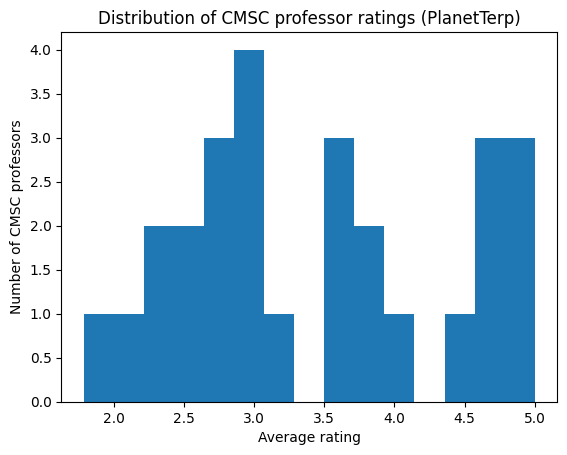

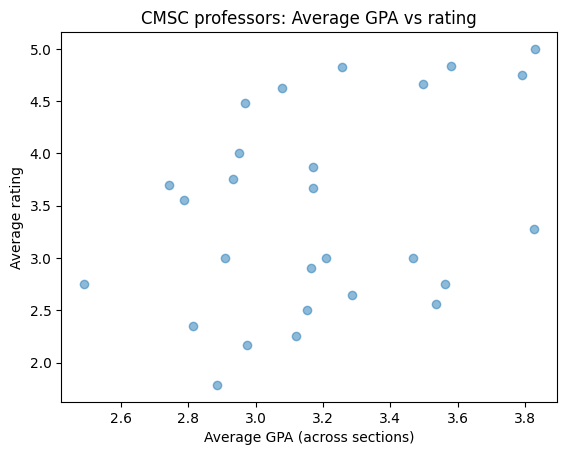

Train size: 20  | Test size: 7

Model comparison (sorted by RMSE):
              model       MAE      RMSE        R2
1      RandomForest  0.455170  0.564757  0.716009
0  LinearRegression  0.608764  0.731823  0.523137
2             Ridge  0.974429  1.004864  0.100924
RandomForest: MAE=0.455, RMSE=0.565, R²=0.716
LinearRegression: MAE=0.609, RMSE=0.732, R²=0.523
Ridge: MAE=0.974, RMSE=1.005, R²=0.101


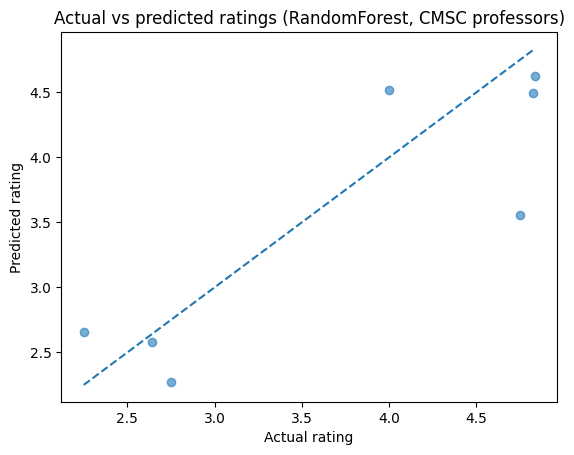

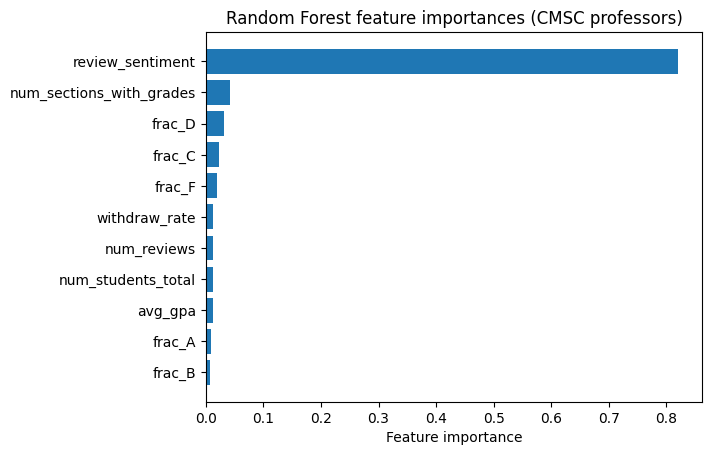


Random Forest feature importances (descending):
review_sentiment            0.821163
num_sections_with_grades    0.042064
frac_D                      0.030767
frac_C                      0.022493
frac_F                      0.018433
withdraw_rate               0.012636
num_reviews                 0.012397
num_students_total          0.012277
avg_gpa                     0.011575
frac_A                      0.008623
frac_B                      0.007572
dtype: float64

Fawzi Emad actual rating: 3.6994
Fawzi grade summary: {'num_sections_with_grades': 260, 'num_students_total': 9345, 'avg_gpa': 2.743838091796169, 'frac_A': 0.3238164076617275, 'frac_B': 0.3277918323093603, 'frac_C': 0.20648114684977714, 'frac_D': 0.0767377424406698, 'frac_F': 0.06517287073846524, 'withdraw_rate': 0.07340823970037454}
Fawzi number of reviews: 316

Fawzi feature vector:
   num_sections_with_grades  num_students_total   avg_gpa    frac_A    frac_B  \
0                       260                9345  2.743838  

In [2]:
!pip install textblob
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 1. PlanetTerp API helpers
API_ROOT = "https://planetterp.com/api/v1"

def call_api(path, params=None):
    url = f"{API_ROOT}{path}"
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()


def get_professors_batch(limit=100, offset=0):
    params = {
        "limit": limit,
        "offset": offset,
        "type": "professor",
    }
    return call_api("/professors", params=params)


def get_professor_details(name, include_reviews=True):
    params = {"name": name}
    if include_reviews:
        # PlanetTerp expects lowercase 'true'/'false' as strings
        params["reviews"] = "true"
    return call_api("/professor", params=params)


def get_grade_records(prof_name):
    # grade distribution
    params = {"professor": prof_name}
    return call_api("/grades", params=params)


# 2. Feature engineering: sentiment + grades

LETTER_BUCKETS = [
    "A+", "A", "A-",
    "B+", "B", "B-",
    "C+", "C", "C-",
    "D+", "D", "D-",
    "F",
]

WITHDRAW_KEY = "W"
OTHER_KEY = "Other"

# Approximate GPA mapping
GPA_MAP = {
    "A+": 4.0, "A": 4.0, "A-": 3.7,
    "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7,
    "D+": 1.3, "D": 1.0, "D-": 0.7,
    "F": 0.0,
}


def mean_sentiment(review_texts):
    if not review_texts:
        return 0.0

    scores = []
    for text in review_texts:
        if isinstance(text, str) and text.strip():
            scores.append(TextBlob(text).sentiment.polarity)

    if not scores:
        return 0.0

    return float(sum(scores) / len(scores))


def summarize_grade_history(grade_rows):
    if not grade_rows:
        return None

    total_letter_counts = {g: 0 for g in LETTER_BUCKETS}
    total_w = 0
    total_other = 0
    total_students = 0
    section_counter = 0

    for entry in grade_rows:
        section_counter += 1
        section_students = 0

        for g in LETTER_BUCKETS:
            c = entry.get(g, 0) or 0
            total_letter_counts[g] += c
            section_students += c

        w_val = entry.get(WITHDRAW_KEY, 0) or 0
        o_val = entry.get(OTHER_KEY, 0) or 0

        total_w += w_val
        total_other += o_val
        section_students += (w_val + o_val)

        total_students += section_students

    total_letter = sum(total_letter_counts.values())
    if total_letter == 0:
        return None

    # Average GPA
    total_quality = 0.0
    for grade, cnt in total_letter_counts.items():
        total_quality += GPA_MAP[grade] * cnt
    avg_gpa = total_quality / total_letter

    def frac(grades):
        num = sum(total_letter_counts[g] for g in grades)
        return num / total_letter

    frac_A = frac(["A+", "A", "A-"])
    frac_B = frac(["B+", "B", "B-"])
    frac_C = frac(["C+", "C", "C-"])
    frac_D = frac(["D+", "D", "D-"])
    frac_F = frac(["F"])

    withdraw_rate = total_w / max(total_students, 1)

    return {
        "num_sections_with_grades": section_counter,
        "num_students_total": total_students,
        "avg_gpa": avg_gpa,
        "frac_A": frac_A,
        "frac_B": frac_B,
        "frac_C": frac_C,
        "frac_D": frac_D,
        "frac_F": frac_F,
        "withdraw_rate": withdraw_rate,
    }

# 3. Build dataset using ONLY CMSC professors

MAX_BATCHES = 10       # how many batches of /professors to look at
BATCH_SIZE = 100       # professors per batch (max 100 per spec)
MAX_PROFESSORS = 140   # hard cap on number of CMSC profs to include

cmsc_prof_names = set()

offset = 0
for batch_idx in range(MAX_BATCHES):
    print(f"Fetching /professors batch {batch_idx+1} (offset={offset})...")
    prof_batch = get_professors_batch(limit=BATCH_SIZE, offset=offset)

    if not prof_batch:
        break

    for p in prof_batch:
        courses = p.get("courses", [])
        # Keep any professor who has at least one CMSC course
        if any(str(c).startswith("CMSC") for c in courses):
            cmsc_prof_names.add(p["name"])

    offset += BATCH_SIZE

print(f"Total unique CMSC-affiliated professors found: {len(cmsc_prof_names)}")

# Always include Fawzi explicitly (in case he somehow wasn't in the batch)
cmsc_prof_names.add("Fawzi Emad")

records = []

for prof_name in sorted(cmsc_prof_names):
    if len(records) >= MAX_PROFESSORS:
        break

    # Fetch professor details
    try:
        details = get_professor_details(prof_name, include_reviews=True)
    except Exception as e:
        print(f"Skipping {prof_name} (details error): {e}")
        continue

    avg_rating = details.get("average_rating")
    if avg_rating is None:
        continue

    review_objs = details.get("reviews", [])
    review_texts = [
        r.get("review", "")
        for r in review_objs
        if isinstance(r, dict)
    ]

    # Fetch grades
    try:
        grade_rows = get_grade_records(prof_name)
    except Exception as e:
        print(f"Skipping {prof_name} (grades error): {e}")
        continue

    grade_summary = summarize_grade_history(grade_rows)
    if grade_summary is None:
        # no usable grades
        continue

    row = {
        "name": prof_name,
        "avg_rating": avg_rating,                     # target variable
        "num_reviews": len(review_texts),
        "review_sentiment": mean_sentiment(review_texts),
    }
    row.update(grade_summary)
    records.append(row)

    if len(records) % 20 == 0:
        print(f"Built feature rows for {len(records)} CMSC professors...")

print("Total CMSC professors in dataset:", len(records))

prof_table = pd.DataFrame(records)
print(prof_table.head())


# Basic cleaning
print("\nSummary statistics:")
print(prof_table.describe(include="all"))

#  distribution of ratings
plt.hist(prof_table["avg_rating"], bins=15)
plt.xlabel("Average rating")
plt.ylabel("Number of CMSC professors")
plt.title("Distribution of CMSC professor ratings (PlanetTerp)")
plt.show()

# GPA vs rating scatter
plt.scatter(prof_table["avg_gpa"], prof_table["avg_rating"], alpha=0.5)
plt.xlabel("Average GPA (across sections)")
plt.ylabel("Average rating")
plt.title("CMSC professors: Average GPA vs rating")
plt.show()


# features /target, train/test split
feature_names = [
    "num_sections_with_grades",
    "num_students_total",
    "avg_gpa",
    "frac_A",
    "frac_B",
    "frac_C",
    "frac_D",
    "frac_F",
    "withdraw_rate",
    "num_reviews",
    "review_sentiment",
]

X = prof_table[feature_names].copy()
y = prof_table["avg_rating"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

print("Train size:", X_train.shape[0], " | Test size:", X_test.shape[0])


# three models /eval
model_dict = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
    ),
    "Ridge": Ridge(alpha=1.0, random_state=42),
}


def get_scores(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5                       #??
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2



results_rows = []

for name, model in model_dict.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae, rmse, r2 = get_scores(y_test, preds)

    results_rows.append({
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    })

results_frame = pd.DataFrame(results_rows).sort_values("RMSE")
print("\nModel comparison (sorted by RMSE):")
print(results_frame)

for _, r in results_frame.iterrows():
    print(
        f"{r['model']}: "
        f"MAE={r['MAE']:.3f}, RMSE={r['RMSE']:.3f}, R²={r['R2']:.3f}"
    )


# 7. Predicted vs actual for best model

best_model_name = results_frame.iloc[0]["model"]
best_model = model_dict[best_model_name]

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.xlabel("Actual rating")
plt.ylabel("Predicted rating")
plt.title(f"Actual vs predicted ratings ({best_model_name}, CMSC professors)")

low = min(y_test.min(), y_pred_best.min())
high = max(y_test.max(), y_pred_best.max())
plt.plot([low, high], [low, high], linestyle="--")
plt.show()


# 8. Feature importance Random Forest

rf_model = model_dict["RandomForest"]
rf_model.fit(X, y)  # train on all data for importance plot

importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=True)

plt.barh(importances_sorted.index, importances_sorted.values)
plt.xlabel("Feature importance")
plt.title("Random Forest feature importances (CMSC professors)")
plt.show()

print("\nRandom Forest feature importances (descending):")
print(importances.sort_values(ascending=False))


# 9. Case study: Fawzi Emad
FOCUS_PROF = "Fawzi Emad"

# Fetch Fawzi's info + reviews
fawzi_details = get_professor_details(FOCUS_PROF, include_reviews=True)
fawzi_rating = fawzi_details.get("average_rating")
fawzi_reviews = [
    r.get("review", "")
    for r in fawzi_details.get("reviews", [])
    if isinstance(r, dict)
]

# Fetch Fawzi's grades
fawzi_grade_rows = get_grade_records(FOCUS_PROF)
fawzi_grade_summary = summarize_grade_history(fawzi_grade_rows)

print("\nFawzi Emad actual rating:", fawzi_rating)
print("Fawzi grade summary:", fawzi_grade_summary)
print("Fawzi number of reviews:", len(fawzi_reviews))

# Build Fawzi feature row
fawzi_row = {
    "num_sections_with_grades": fawzi_grade_summary["num_sections_with_grades"],
    "num_students_total": fawzi_grade_summary["num_students_total"],
    "avg_gpa": fawzi_grade_summary["avg_gpa"],
    "frac_A": fawzi_grade_summary["frac_A"],
    "frac_B": fawzi_grade_summary["frac_B"],
    "frac_C": fawzi_grade_summary["frac_C"],
    "frac_D": fawzi_grade_summary["frac_D"],
    "frac_F": fawzi_grade_summary["frac_F"],
    "withdraw_rate": fawzi_grade_summary["withdraw_rate"],
    "num_reviews": len(fawzi_reviews),
    "review_sentiment": mean_sentiment(fawzi_reviews),
}

fawzi_features = pd.DataFrame([fawzi_row])[feature_names]
print("\nFawzi feature vector:")
print(fawzi_features)

# Predict Fawzi's rating with each model
fawzi_rows = []
for name, model in model_dict.items():
    model.fit(X, y)
    predicted = float(model.predict(fawzi_features)[0])

    fawzi_rows.append({
        "model": name,
        "predicted_rating": predicted,
        "actual_rating": fawzi_rating,
        "absolute_error": abs(predicted - fawzi_rating),
    })

fawzi_results = pd.DataFrame(fawzi_rows)
print("\nFawzi Emad prediction results:")
print(fawzi_results)

for _, r in fawzi_results.iterrows():
    print(
        f"{r['model']}: predicted={r['predicted_rating']:.3f}, "
        f"actual={r['actual_rating']:.3f}, "
        f"|error|={r['absolute_error']:.3f}"
    )
